** Notes **
* Be very careful when constructing the resolution matrix. If missed by a transpose, the result will be wrong!!

In [1]:
# %cd ~/dev/graphite-DOS/irradiated-notebooks/

In [2]:
from __future__ import (absolute_import, division, print_function)

import os, sys
import numpy as np
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
from scipy.interpolate import interp1d
import warnings
from numpy import linalg as LA

In [3]:
# %matplotlib notebook
%matplotlib inline

In [4]:
sys.path.insert(0, '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/')
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')

In [5]:
# sys.path.insert(0, '/home/lj7/dv/srins/srins/')
# sys.path.insert(0, '/SNS/users/lj7/dv/srins/srins-jiao/')

In [6]:
import srins

In [7]:
import srins.powder.linearizedBregman as splb; reload(splb)
import srins.powder.conv_deconv as spcd
import srins.powder.Lucy_Richardson as LR; reload(LR)
import srins.powder.bregmanSplit as spbs; 
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc
reload(spbs)

!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.pyc
reload(LR)

<module 'srins.powder.Lucy_Richardson' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.py'>

In [8]:
from srins.powder.conv_deconv import convolve_NS as F

In [9]:
import srins.powder.linearizedBregman as splb; reload(splb)

<module 'srins.powder.linearizedBregman' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc'>

In [10]:
Eaxis = np.arange(-50, 240, 0.1)

In [11]:
def gauss(x, center, ht, sigma):
    return ht * np.exp(-(x-center)**2/2/sigma**2)

# Try deconvoling asymmetric resolution - two gaussians

In [12]:
def twogauss(x, center, ht, sigma_left, sigma_right):
    lcenter = -sigma_left*np.sqrt(2/np.pi)
    rcenter = +sigma_right*np.sqrt(2/np.pi)
    center1 = (lcenter*sigma_left + rcenter*sigma_right) / (sigma_left+sigma_right)
    center -= center1
    y = gauss(x, center, ht, sigma_left)
    y[x>center] = gauss(x[x>center], center, ht, sigma_right)
    y/=y.sum()
    return y

(80, 110)

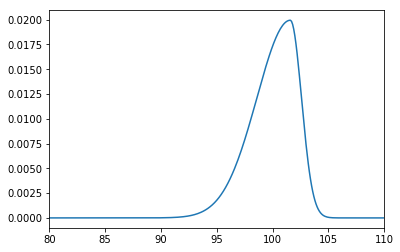

In [13]:
plt.figure()
plt.plot(Eaxis, twogauss(Eaxis, 100., 1., 3, 1))
plt.xlim(80, 110)

## Create resolution matrix

In [14]:
N = Eaxis.size

In [15]:
res_mat = np.zeros((N, N))

In [16]:
for i in range(N):
    res_mat[i] = twogauss(Eaxis, Eaxis[i], 1., 5, 1)

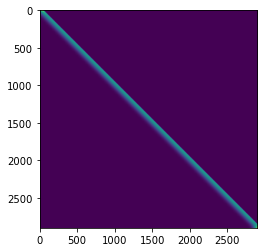

In [17]:
plt.figure()
plt.imshow(res_mat)

## Gaussian function convolved with resolution function

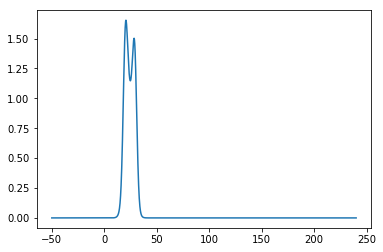

In [20]:
y = gauss(Eaxis, 20, 1, 2)+gauss(Eaxis, 29, 1, 2)+gauss(Eaxis, 24, 1, 4)
# y_delta[1000] = y_delta[1200] = 1.
plt.figure()
plt.plot(Eaxis,y)
plt.show()

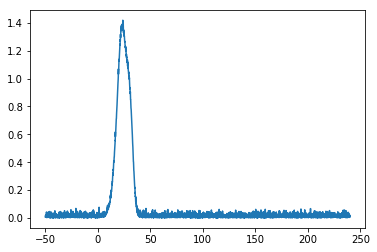

In [21]:
 n=0.02 #[0.002 ,0.004, 0.006, 0.008, 0.01, 0.02]

plt.figure()
y3 = np.dot(y, res_mat)+np.abs(n * np.random.normal(size=N))
plt.plot(Eaxis, y3)
# plt.xlim(20, 120)

## Linearized Bregman

In [22]:
RF_T = np.transpose(res_mat)
m = F(RF_T, res_mat)
max_delta = 2. / LA.norm(m, ord=1)
print (max_delta)

1.71731617029


In [23]:
ini_uZ = np.zeros(Eaxis.shape[0])
ini_vZ = np.zeros(Eaxis.shape[0])
neu_N = 1 / np.sqrt(N)
print(neu_N)

0.0185695338177


In [24]:
delta = max_delta

In [25]:
RV, RU, error, it, errorBL = splb.bregman_NS(y3, res_mat, ini_vZ, ini_uZ, neu_N, delta, 'error', 0.0005, maxIter=100)

number of iteration: 100


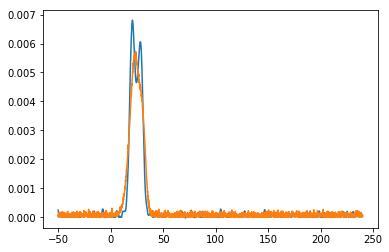

In [26]:
plt.figure()
plt.plot(Eaxis, RU/RU.sum())
plt.plot(Eaxis, y3/y3.sum())
plt.show()
# plt.plot(Eaxis,y_delta/y_delta.sum())

# Bregman Split

In [27]:
recSplit= spbs.split_Bregman(y3, res_mat, ini_vZ, ini_uZ, 40, 0.001, 10, 10, 5)

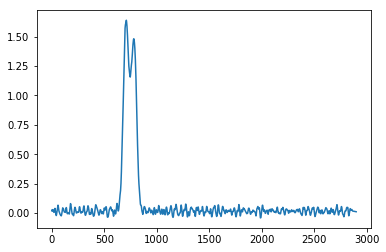

In [28]:
plt.figure()
plt.plot(recSplit)
plt.show()

In [29]:
import bregmanSplit as oriSP

In [30]:
recSplitO= oriSP.split_Bregman(y3, res_mat, ini_vZ, ini_uZ, 40, 0.0001, 10, 10, 5)

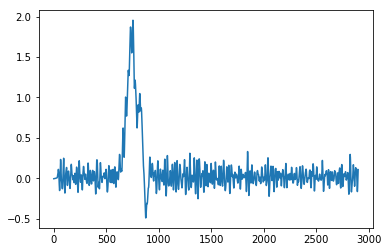

In [31]:
plt.figure()
plt.plot(recSplitO)
plt.show()

# Lucy Richardson

In [32]:
ini1=(np.sum(y3,0)/len(y3)) * np.ones(len(y3))#initial guess
R,E,In=LR.deconvolve_NS(y3, res_mat, ini1, 'iteration', 100)

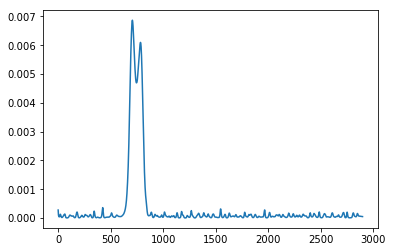

In [33]:
plt.figure()
plt.plot(R/R.sum())
# plt.plot(y_delta/y_delta.sum())
plt.show()

In [34]:
import srins.powder.Lucy_Richardson_Nregularized as LRr

In [35]:
Rr,Er,Inr=LRr.deconvolve_NS(y3, res_mat, ini1,1,1,'iteration', 1)

In [36]:
print (Inr)

1


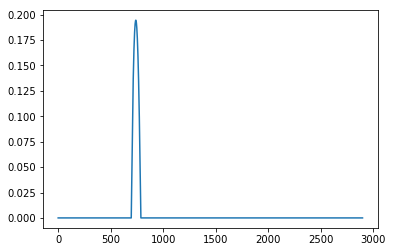

In [37]:
plt.figure()
plt.plot(Rr)
plt.show()

# regularized Lucy Richardson 

In [38]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm.pyc
import srins.powder.Regularized_LucyRichardson_L1norm as L1lr
reload(L1lr)

<module 'srins.powder.Regularized_LucyRichardson_L1norm' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm.pyc'>

In [39]:
r1=L1lr.deconvolve_L1_NS(y3, res_mat, ini1, 0.004, 0.0001, 'iteration', 100)

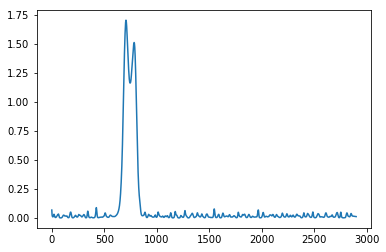

In [40]:
plt.figure()
plt.plot(r1)
plt.show()

In [41]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm_ed2.pyc

import srins.powder.Regularized_LucyRichardson_L1norm_ed2 as l1n
reload(l1n)

<module 'srins.powder.Regularized_LucyRichardson_L1norm_ed2' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm_ed2.pyc'>

In [42]:
r2=l1n.deconvolve_L1_NS(y3, res_mat, ini1, 5, 'iteration', 50)

/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm_ed2.py:74: RuntimeWarning: invalid value encountered in divide
  dif1=np.ediff1d(deconv, to_begin=0)/np.sum(np.abs(np.ediff1d(deconv, to_begin=0)))


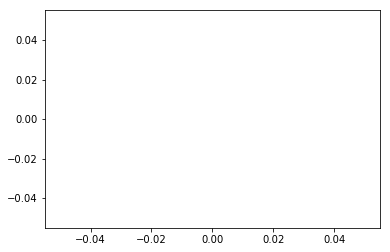

In [43]:
plt.figure()
plt.plot (r2)
plt.show()

# comparison

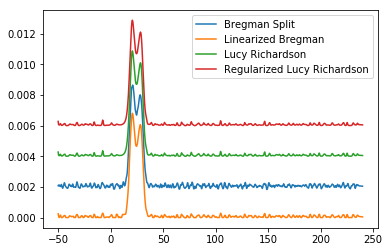

In [44]:
plt.figure()
# plt.plot(Eaxis, RU/RU.sum(), label='Linearized Bregman')
plt.plot(Eaxis, recSplit/recSplit.sum()+0.002, label='Bregman Split')
plt.plot(Eaxis, RU/RU.sum(), label='Linearized Bregman')

plt.plot(Eaxis,R/R.sum()+0.004,label='Lucy Richardson')
plt.plot(Eaxis, r1/r1.sum()+0.006,label='Regularized Lucy Richardson')
plt.legend(loc='upper right')
# plt.xlim(0,200)
plt.show()